In [1]:
import json
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import time
import seaborn as sns
import regex

from datetime import datetime

In [2]:
# !pip install emoji

In [3]:
import nltk
import contractions
import re
import emoji
import emojis
import wordcloud as wc
import string

from collections import Counter

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer


In [5]:

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
stop_words = nltk.corpus.stopwords.words('spanish')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [6]:
data = pd.read_csv('data_tweets_model.csv')

In [7]:
print(data.shape)
data.head(3)

(9846, 34)


,created_at,status_id,user_id,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favourites_count,retweet_count,place_full_name,place_type,followers_count,friends_count,account_created_at,verified,source_tweet,is_reply,hashtags,Sentiment,Mixed,Negative,Neutral,Positive,mentions,emojis,REGION,CÓDIGO DANE DEL DEPARTAMENTO,DEPARTAMENTO,CÓDIGO DANE DEL MUNICIPIO,score
0,2020-03-29 00:00:37,1244051801516711938,803282972317204480,redcomunitariat,Este lunes estaremos hablando sobre la situaci...,Twitter for iPhone,NaN,NaN,NaN,False,False,1119,4,SANTAFE DE BOGOTA D.C,city,2710,365,2016-11-28 17:02:39,False,https://twitter.com/redcomunitariat/status/124...,0,['#Covid_19'],NEUTRAL,0.000015,0.027391,0.522266,0.450328,['@PlayGrounder'],[],Región Centro Oriente,11.0,SANTAFE DE BOGOTA D.C,11001.0,1
1,2020-03-29 00:01:33,1244052036511051778,2476348920,SebasCamposCol,Aquí con frío🥶 viendo cómo pasa la cuarentena🕯...,Twitter for Android,NaN,NaN,NaN,False,False,768,0,SANTAFE DE BOGOTA D.C,city,4194,204,2014-05-04 04:11:55,False,https://twitter.com/SebasCamposCol/status/1244...,0,"['#yomequedoencasa', '#coronavirus']",NEUTRAL,0.001591,0.085628,0.811555,0.101227,[],"['🥶', '🕯']",Región Centro Oriente,11.0,SANTAFE DE BOGOTA D.C,11001.0,1
2,2020-03-29 00:02:45,1244052338412847104,239176842,Jonathan_518,"Hoy es #sábado, apenas es hora de bañarme y or...",Twitter for iPhone,NaN,NaN,NaN,False,False,18,0,GUARNE,city,286,914,2011-01-17 00:53:22,False,https://twitter.com/Jonathan_518/status/124405...,0,"['#sábado', '#Coronavirus', '#Covid_19']",NEUTRAL,0.000012,0.002819,0.864167,0.133002,[],['🙄'],Región Eje Cafetero - Antioquia,5.0,ANTIOQUIA,5318.0,1


In [8]:
data['score'] = (data['Positive'] > data['Negative']).apply(lambda x: 0 if x else 1)

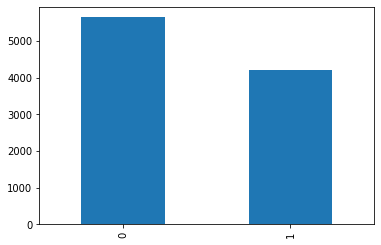

In [9]:
data['score'].value_counts().plot.bar()

In [10]:
def create_wordcloud(text, plt_):
    wordcloud = wc.WordCloud(max_font_size=50,
                          max_words=100,
                          scale=10,
                          background_color="white")\
                          .generate(text)
    plt.figure(figsize=(10,5))
    plt_.imshow(wordcloud, interpolation="bilinear")
    plt_.axis("off")
#     plt.show()
    
def remove_links(text):
    text_ = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    return text_


def get_emojis(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

    
def get_hashtags(text):
    patter = re.compile(r"#(\w+)")
    all_hashtags = [f"#{i}" for i in patter.findall(text)]
    return all_hashtags

def get_mentions(text):
    patter = re.compile(r"@(\w+)")
    all_hashtags = [f"@{i}" for i in patter.findall(text)]
    return all_hashtags

def remove_special_characters(text):
    punctuation = string.punctuation+"¡"
    text = re.sub(f"[{punctuation}]", '', text)
    return text

def remove_repeated_word(text):
    tokens = nltk.word_tokenize(" ".join(data3['text']))
    

def remove_stopwords(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    filtered_text = " ".join(filtered_tokens)    
    return filtered_text

def clean_df(df):
    df['text'] = df['text'].apply(lambda x: x.replace('#', ''))
    df['text'] = df['text'].apply(lambda x: x.replace('@', ''))
    return df

In [11]:
data_ = data[~data['text'].isnull()].copy()

In [12]:
data_ = clean_df(data_)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data_[['text']], data_['score'], random_state=42)
X_train.shape, X_test.shape

((7374, 1), (2459, 1))

### Count based Features

In [14]:
X_train['char_count'] = X_train['text'].apply(len)
X_train['word_count'] = X_train['text'].apply(lambda x: len(x.split()))
X_train['word_density'] = X_train['char_count'] / (X_train['word_count']+1)
X_train['punctuation_count'] = X_train['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
X_train['title_word_count'] = X_train['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
X_train['upper_case_word_count'] = X_train['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))


X_test['char_count'] = X_test['text'].apply(len)
X_test['word_count'] = X_test['text'].apply(lambda x: len(x.split()))
X_test['word_density'] = X_test['char_count'] / (X_test['word_count']+1)
X_test['punctuation_count'] = X_test['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
X_test['title_word_count'] = X_test['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
X_test['upper_case_word_count'] = X_test['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [15]:
X_train.head()

,text,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count
6512,AEstaHora otro punto de la ciudad es parte de ...,180,30,5.806452,2,1,1
7717,COVID-19 | Colombia | 24abr2020\nVersión .pdf:...,77,10,7.000000,6,4,2
1994,Cifras sobre la ampliación de los servicios de...,159,23,6.625000,1,2,1
5177,En la reunión virtual 👩🏻‍💻que llevamos a esta ...,189,28,6.517241,1,2,3
7791,¿Cuál es el mejor material para un tapabocas c...,53,9,5.300000,1,1,0


## Training a Logistic Model

In [16]:
log_reg = LogisticRegression(C=1, random_state=42, solver='liblinear')

In [17]:
log_reg.fit(X_train.drop(['text'], axis=1), y_train)
predictions = log_reg.predict(X_test.drop(['text'], axis=1))

In [18]:
log_reg.coef_

array([[-0.0086319 ,  0.07836795, -0.11171836,  0.03890717, -0.07872397,
         0.01427874]])

## Model Evaluation

In [19]:
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.64      0.78      0.70      1418
           1       0.57      0.39      0.46      1041

    accuracy                           0.62      2459
   macro avg       0.60      0.59      0.58      2459
weighted avg       0.61      0.62      0.60      2459



,0,1
0,1110,308
1,633,408


## Text Pre-processing and Wrangling

In [20]:
nltk.stem.snowball

<module 'nltk.stem.snowball' from '/usr/local/lib/python3.6/dist-packages/nltk/stem/snowball.py'>

In [21]:
# ps = nltk.porter.PorterStemmer()
from nltk.stem.snowball import SnowballStemmer
snowball_stemmer = SnowballStemmer('spanish')

# from nltk.stem import PorterStemmer
# porter = PorterStemmer()

def simple_text_preprocessor(document): 
    # lower case
    document = str(document).lower()
    
    # simple porter stemming
    document = ' '.join([snowball_stemmer.stem(word) for word in document.split()])
    
#     # stopwords removal
    document = ' '.join([word for word in document.split() if word not in stop_words])
    
    return document

stp = np.vectorize(simple_text_preprocessor)

In [22]:
X_train['Clean text'] = stp(X_train['text'].values)
X_test['Clean text'] = stp(X_test['text'].values)

X_train.head()

,text,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,Clean text
6512,AEstaHora otro punto de la ciudad es parte de ...,180,30,5.806452,2,1,1,aestahor punt ciud part tamizaje. busqued acti...
7717,COVID-19 | Colombia | 24abr2020\nVersión .pdf:...,77,10,7.000000,6,4,2,covid-19 | colombi | 24abr2020 version .pdf: c...
1994,Cifras sobre la ampliación de los servicios de...,159,23,6.625000,1,2,1,"cifr sobr ampliacion servici baja, median alta..."
5177,En la reunión virtual 👩🏻‍💻que llevamos a esta ...,189,28,6.517241,1,2,3,reunion virtual 👩🏻‍💻qu llev hor ips revis capa...
7791,¿Cuál es el mejor material para un tapabocas c...,53,9,5.300000,1,1,0,¿cual mejor material par tapaboc casero?


In [23]:
X_train_metadata = X_train.drop(['text', 'Clean text'], axis=1).reset_index(drop=True)
X_test_metadata = X_test.drop(['text', 'Clean text'], axis=1).reset_index(drop=True)

X_train_metadata.head()

,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count
0,180,30,5.806452,2,1,1
1,77,10,7.000000,6,4,2
2,159,23,6.625000,1,2,1
3,189,28,6.517241,1,2,3
4,53,9,5.300000,1,1,0


## Adding Bag of Words based Features - 1-grams

In [24]:

cv = CountVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1, 1))
X_traincv = cv.fit_transform(X_train['Clean text']).toarray()
X_traincv = pd.DataFrame(X_traincv, columns=cv.get_feature_names())

X_testcv = cv.transform(X_test['Clean text']).toarray()
X_testcv = pd.DataFrame(X_testcv, columns=cv.get_feature_names())
X_traincv.head()

,00,000,0000,0001,000m,002,003,0037,00am,00m,00pm,01,012,015,017,018000,01abr,02,020,021,0222,026,02o___,03,0329,034,04,041,0420,042020,04abr,05,051,05abril,06,065,06abr,07,07abr,08,...,𝕕𝕒𝕣,𝕖𝕝𝕖𝕔𝕔𝕚𝕠𝕟𝕖𝕤,𝕖𝕞𝕡𝕚𝕖𝕔𝕖𝕟,𝕝𝕠𝕤,𝕞𝕖𝕣𝕔𝕒𝕕𝕠𝕤,𝕟𝕠,𝕡𝕒𝕣𝕒,𝕡𝕝𝕒𝕥𝕒,𝕡𝕠𝕝𝕚𝕥𝕚𝕔𝕠𝕤,𝕢𝕦𝕖,𝗟𝗮𝗢𝘁𝗿𝗮𝗣𝗮𝗻𝗱𝗲𝗺𝗶𝗮,𝗣𝗮𝗻𝗲𝗹𝗶𝘀𝘁𝗮,𝗪𝗲𝗯𝗶𝗻𝗮𝗿𝗥𝗲𝗰𝗼𝗻,𝘾𝙤𝙫𝙞𝙙,𝙔𝙖,𝙡𝙖𝙫𝙖𝙨𝙩𝙚,𝙢𝙖𝙣𝙤𝙨,𝙩𝙪𝙨,𝙰𝚕,𝙰𝚚𝚞𝚒,𝙲𝚘,𝙲𝚘𝚟𝚒𝚍19,𝙶𝚕𝚘𝚋𝚊𝚕,𝙻𝚘𝚐𝚒𝚜𝚝𝚒𝚌,𝚊𝚏𝚎𝚌𝚝𝚊𝚍𝚘𝚜,𝚊𝚕,𝚊𝚙𝚕𝚒𝚌𝚊𝚛,𝚌𝚘𝚖𝚙𝚊𝚛𝚝𝚘,𝚌𝚞𝚋𝚛𝚎,𝚍𝚎,𝚎𝚕,𝚎𝚖𝚎𝚛𝚐𝚎𝚗𝚌𝚒𝚊,𝚎𝚡𝚝𝚛𝚊𝚗𝚓𝚎𝚛𝚘𝚜,𝚕𝚎𝚜,𝚙𝚊𝚛𝚊,𝚙𝚊𝚛𝚎𝚌𝚎𝚛,𝚙𝚘𝚛,𝚜𝚞𝚋𝚜𝚒𝚍𝚒𝚘,𝚝𝚊𝚖𝚋𝚒𝚎,𝚟𝚎𝚛𝚗𝚘𝚜
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
X_train_comb = pd.concat([X_train_metadata, X_traincv], axis=1)
X_test_comb = pd.concat([X_test_metadata, X_testcv], axis=1)

X_train_comb.head()

,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,00,000,0000,0001,000m,002,003,0037,00am,00m,00pm,01,012,015,017,018000,01abr,02,020,021,0222,026,02o___,03,0329,034,04,041,0420,042020,04abr,05,051,05abril,...,𝕕𝕒𝕣,𝕖𝕝𝕖𝕔𝕔𝕚𝕠𝕟𝕖𝕤,𝕖𝕞𝕡𝕚𝕖𝕔𝕖𝕟,𝕝𝕠𝕤,𝕞𝕖𝕣𝕔𝕒𝕕𝕠𝕤,𝕟𝕠,𝕡𝕒𝕣𝕒,𝕡𝕝𝕒𝕥𝕒,𝕡𝕠𝕝𝕚𝕥𝕚𝕔𝕠𝕤,𝕢𝕦𝕖,𝗟𝗮𝗢𝘁𝗿𝗮𝗣𝗮𝗻𝗱𝗲𝗺𝗶𝗮,𝗣𝗮𝗻𝗲𝗹𝗶𝘀𝘁𝗮,𝗪𝗲𝗯𝗶𝗻𝗮𝗿𝗥𝗲𝗰𝗼𝗻,𝘾𝙤𝙫𝙞𝙙,𝙔𝙖,𝙡𝙖𝙫𝙖𝙨𝙩𝙚,𝙢𝙖𝙣𝙤𝙨,𝙩𝙪𝙨,𝙰𝚕,𝙰𝚚𝚞𝚒,𝙲𝚘,𝙲𝚘𝚟𝚒𝚍19,𝙶𝚕𝚘𝚋𝚊𝚕,𝙻𝚘𝚐𝚒𝚜𝚝𝚒𝚌,𝚊𝚏𝚎𝚌𝚝𝚊𝚍𝚘𝚜,𝚊𝚕,𝚊𝚙𝚕𝚒𝚌𝚊𝚛,𝚌𝚘𝚖𝚙𝚊𝚛𝚝𝚘,𝚌𝚞𝚋𝚛𝚎,𝚍𝚎,𝚎𝚕,𝚎𝚖𝚎𝚛𝚐𝚎𝚗𝚌𝚒𝚊,𝚎𝚡𝚝𝚛𝚊𝚗𝚓𝚎𝚛𝚘𝚜,𝚕𝚎𝚜,𝚙𝚊𝚛𝚊,𝚙𝚊𝚛𝚎𝚌𝚎𝚛,𝚙𝚘𝚛,𝚜𝚞𝚋𝚜𝚒𝚍𝚒𝚘,𝚝𝚊𝚖𝚋𝚒𝚎,𝚟𝚎𝚛𝚗𝚘𝚜
0,180,30,5.806452,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,77,10,7.000000,6,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,159,23,6.625000,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,189,28,6.517241,1,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,53,9,5.300000,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Model Training and Evaluation

In [26]:
log_reg.fit(X_train_comb, y_train)
predictions = log_reg.predict(X_test_comb)

log_reg.coef_

array([[-0.00091642,  0.06229296, -0.17914691, ..., -0.10746255,
        -0.10746255, -0.10746255]])

In [27]:
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1418
           1       0.73      0.70      0.71      1041

    accuracy                           0.76      2459
   macro avg       0.76      0.76      0.76      2459
weighted avg       0.76      0.76      0.76      2459



,0,1
0,1154,264
1,315,726


## SVM

In [28]:
from sklearn import svm

In [29]:
svm_m = svm.SVC()
svm_m.fit(X_train_metadata, y_train)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [30]:
predictions = svm_m.predict(X_test_metadata)


In [31]:
# predictions.

In [32]:
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.60      0.90      0.72      1418
           1       0.59      0.20      0.30      1041

    accuracy                           0.60      2459
   macro avg       0.60      0.55      0.51      2459
weighted avg       0.60      0.60      0.54      2459



,0,1
0,1275,143
1,835,206


## Neural network

In [33]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import nltk
from nltk import word_tokenize
from wordcloud import WordCloud
nltk.download('stopwords')
import re

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

try:
    tf.set_random_seed(1337)                    # set the random seed for reproducibility
except:
    tf.random.set_seed(1337)                     # NOTE: Newer version of tensorflow uses tf.random.set_seed
np.random.seed(1337)                         #       instead of tf.set_random_seed

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
def plot_validation_model(hist_):
    history_dict = hist_.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss=history_dict['loss']
    val_loss=history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(8,6))
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    # plt.ylim((0.5,1))
    plt.show()
    
    acc_ = [(acc[i], val_acc[i]) for i in range(len(acc))]
    acc_.sort(key=lambda x: (x[0], x[1]), reverse=True)
    return acc_[1]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data_['text'], 
                                                    data_['score'],
                                                    test_size=0.2)

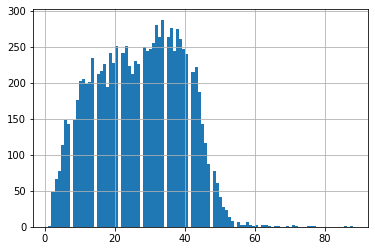

In [36]:
number_words_per_review = data_['text'].apply(lambda x: len(str(x).split(' ')) if not x in stop_words else 0)
number_words_per_review.hist(bins=100)

In [37]:
perc80np = np.percentile(number_words_per_review, 80)
print(f"Percentil 80th: {perc80np}")

Percentil 80th: 39.0


In [38]:
print(len(nltk.word_tokenize(" ".join(X_train)))*0.8)

181439.2


In [39]:
tokenizer = Tokenizer(num_words=180000) #We create the tokenizer using only top 20000 words
tokenizer.fit_on_texts(X_train)  #Then, we create the text->indices mapping. 

In [40]:
train_sequence = tokenizer.texts_to_sequences(X_train)
test_sequence = tokenizer.texts_to_sequences(X_test)

train_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequence, 39)
test_sequences = tf.keras.preprocessing.sequence.pad_sequences(test_sequence, 39)

In [41]:
model = Sequential()
model.add(Embedding(181700, 128, input_length=39))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 39, 128)           23257600  
_________________________________________________________________
dense (Dense)                (None, 39, 128)           16512     
_________________________________________________________________
dense_1 (Dense)              (None, 39, 128)           16512     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 23,290,882
Trainable params: 23,290,882
Non-trainable params: 0
_________________________________________________________________


In [43]:
print(train_sequences.shape)
print(y_train.shape)

(7866, 39)
(7866,)


In [44]:
history = model.fit(train_sequences, y_train, validation_split=0.2, epochs=10)

Epoch 1/10
197/197 [==============================] - 43s 220ms/step - loss: 0.6128 - accuracy: 0.6615 - val_loss: 0.5145 - val_accuracy: 0.7630
Epoch 2/10
197/197 [==============================] - 43s 218ms/step - loss: 0.3992 - accuracy: 0.8249 - val_loss: 0.4719 - val_accuracy: 0.7789
Epoch 3/10
197/197 [==============================] - 42s 215ms/step - loss: 0.1590 - accuracy: 0.9444 - val_loss: 0.6461 - val_accuracy: 0.7529
Epoch 4/10
197/197 [==============================] - 43s 218ms/step - loss: 0.0416 - accuracy: 0.9894 - val_loss: 0.8127 - val_accuracy: 0.7618
Epoch 5/10
197/197 [==============================] - 43s 217ms/step - loss: 0.0167 - accuracy: 0.9963 - val_loss: 0.8698 - val_accuracy: 0.7503
Epoch 6/10
197/197 [==============================] - 43s 219ms/step - loss: 0.0116 - accuracy: 0.9973 - val_loss: 0.9473 - val_accuracy: 0.7567
Epoch 7/10
197/197 [==============================] - 42s 214ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 1.0071 - val_ac

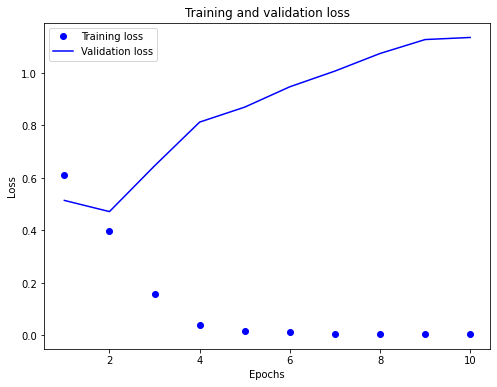

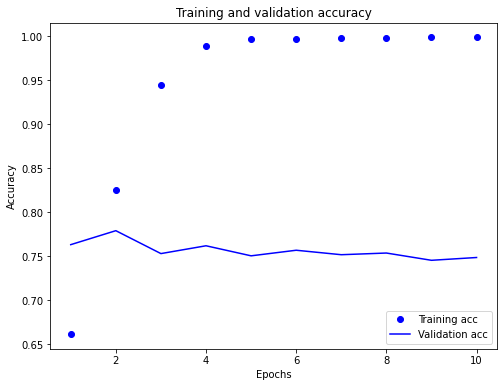

(0.9985696077346802, 0.7452350854873657)

In [45]:
plot_validation_model(history)

In [46]:
model2 = Sequential()
model2.add(Embedding(181700, 128, input_length=39))
model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(Dense(128, activation='relu')) 
model2.add(Dense(128, activation='relu'))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(2, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history2 = model2.fit(train_sequences, y_train, validation_split=0.2, epochs=10)

Epoch 1/10
197/197 [==============================] - 44s 222ms/step - loss: 0.6204 - accuracy: 0.6613 - val_loss: 0.5181 - val_accuracy: 0.7471
Epoch 2/10
197/197 [==============================] - 43s 220ms/step - loss: 0.4304 - accuracy: 0.8001 - val_loss: 0.4720 - val_accuracy: 0.7662
Epoch 3/10
197/197 [==============================] - 43s 220ms/step - loss: 0.2149 - accuracy: 0.9142 - val_loss: 0.5772 - val_accuracy: 0.7490
Epoch 4/10
197/197 [==============================] - 43s 220ms/step - loss: 0.0741 - accuracy: 0.9762 - val_loss: 0.7208 - val_accuracy: 0.7586
Epoch 5/10
197/197 [==============================] - 44s 221ms/step - loss: 0.0265 - accuracy: 0.9936 - val_loss: 0.8942 - val_accuracy: 0.7510
Epoch 6/10
197/197 [==============================] - 43s 220ms/step - loss: 0.0121 - accuracy: 0.9975 - val_loss: 0.9511 - val_accuracy: 0.7548
Epoch 7/10
197/197 [==============================] - 43s 219ms/step - loss: 0.0073 - accuracy: 0.9984 - val_loss: 1.0337 - val_ac

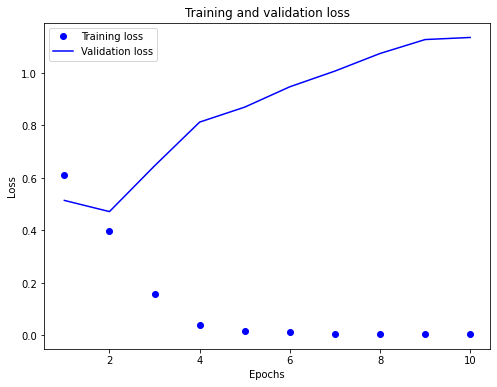

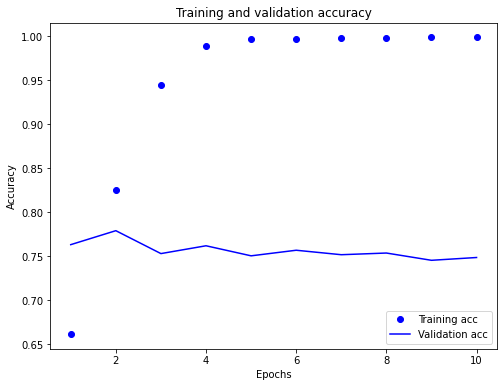

(0.9985696077346802, 0.7452350854873657)

In [47]:
plot_validation_model(history)

In [48]:
model3 = Sequential()
model3.add(Embedding(80000, 128, input_length=39))
model3.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model3.add(Dense(128, activation='relu')) 
model3.add(Dropout(0.2))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.2))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(2, activation='sigmoid'))
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [49]:
history3 = model3.fit(train_sequences, y_train, validation_split=0.2, epochs=10)


Epoch 1/10
197/197 [==============================] - 23s 117ms/step - loss: 0.6297 - accuracy: 0.6435 - val_loss: 0.5608 - val_accuracy: 0.7313
Epoch 2/10
197/197 [==============================] - 23s 114ms/step - loss: 0.4679 - accuracy: 0.7748 - val_loss: 0.5154 - val_accuracy: 0.7433
Epoch 3/10
197/197 [==============================] - 23s 115ms/step - loss: 0.2696 - accuracy: 0.8908 - val_loss: 0.5223 - val_accuracy: 0.7503
Epoch 4/10
197/197 [==============================] - 23s 115ms/step - loss: 0.1243 - accuracy: 0.9572 - val_loss: 0.6312 - val_accuracy: 0.7370
Epoch 5/10
197/197 [==============================] - 23s 115ms/step - loss: 0.0529 - accuracy: 0.9828 - val_loss: 0.8647 - val_accuracy: 0.7173
Epoch 6/10
197/197 [==============================] - 23s 115ms/step - loss: 0.0239 - accuracy: 0.9925 - val_loss: 1.0237 - val_accuracy: 0.7173
Epoch 7/10
197/197 [==============================] - 23s 115ms/step - loss: 0.0156 - accuracy: 0.9962 - val_loss: 1.0924 - val_ac

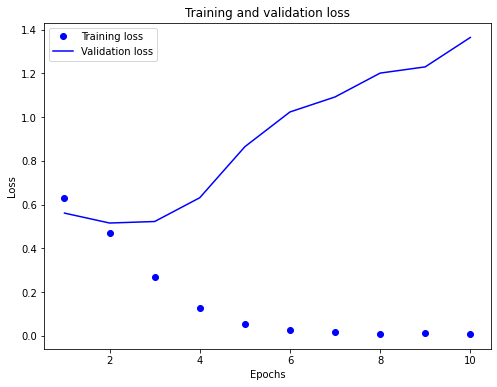

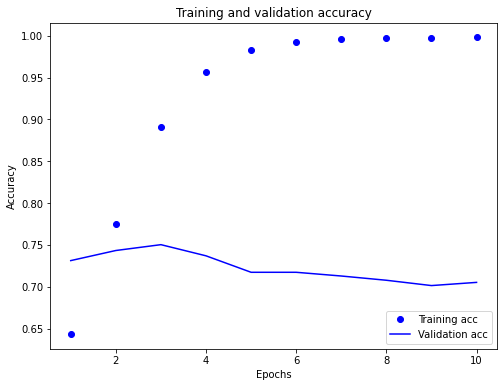

(0.9974570870399475, 0.7077509760856628)

In [50]:
plot_validation_model(history3)

Lambda: 0.0001
Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


197/197 [==============================] - 43s 219ms/step - loss: 6.3699 - accuracy: 0.6392 - val_loss: 0.8858 - val_accuracy: 0.7141
Epoch 2/10
197/197 [==============================] - 43s 218ms/step - loss: 0.8904 - accuracy: 0.7061 - val_loss: 0.8710 - val_accuracy: 0.7179
Epoch 3/10
197/197 [==============================] - 43s 219ms/step - loss: 0.8771 - accuracy: 0.7287 - val_loss: 0.8696 - val_accuracy: 0.7452
Epoch 4/10
197/197 [==============================] - 43s 219ms/step - loss: 0.8653 - accuracy: 0.7455 - val_loss: 0.8943 - val_accuracy: 0.7376
Epoch 5/10
197/197 [==============================] - 43s 218ms/step - loss: 0.8623 - accuracy: 0.7665 - val_loss: 0.8974 - val_accuracy: 0.7535
Epoch 6/10
197/197 [==============================] - 43s 217ms/step - loss: 0.8507 - accuracy: 0.7832 - val_loss: 0.9077 - val_accuracy: 0.7541
Epoch 7/10
197/197 [==============================] - 43s 219ms/step - loss: 0.8301 - accuracy: 0.8047 - val_loss: 0.9171 - val_accuracy: 0.7

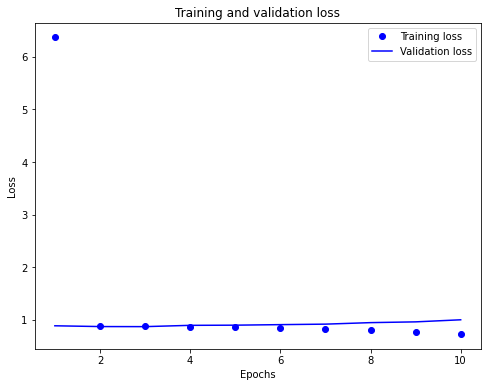

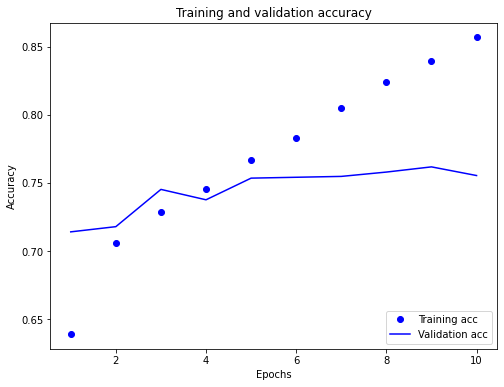

(0.8396376371383667, 0.761753499507904)

In [51]:
c = 1/10000
print(f"Lambda: {c}")

model7 = Sequential()
model7.add(Embedding(180000, 128, input_length=39, embeddings_regularizer=regularizers.l1(c)))
model7.add(Dense(128, activation='relu', activity_regularizer=regularizers.l2(c))) 
model7.add(Dense(128, activation='relu', activity_regularizer=regularizers.l2(c)))
model7.add(GlobalMaxPooling1D())
model7.add(Dense(2, activation='sigmoid'))
model7.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history7 = model7.fit(train_sequences, y_train, validation_split=0.2, epochs=10)
plot_validation_model(history7)


In [53]:
c = 1/100000
print(f"Lambda: {c}")

model8 = Sequential()
model8.add(Embedding(180000, 128, input_length=39, embeddings_regularizer=regularizers.l1(c)))
model8.add(Dense(128, activation='relu', activity_regularizer=regularizers.l2(c))) 
model8.add(Dense(128, activation='relu', activity_regularizer=regularizers.l2(c)))
model8.add(GlobalMaxPooling1D())
model8.add(Dense(2, activation='sigmoid'))
model8.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks_ = [
    tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
            baseline=None, restore_best_weights=False
            )
]

history8 = model8.fit(train_sequences, y_train, validation_split=0.2, epochs=10, callbacks=callbacks_)
plot_validation_model(history8)